# Set Up
## Import

In [13]:
import cupy as cp
import numpy as np
from numba import jit, prange, njit, vectorize
import pandas
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time

## Settings

In [15]:
#CAUTION: if R is chosen too small and N too high, then when the program will try to calculate the inverse of dGr
# in the calculation of the saturated density profile, the following error will show: 'Matrix singular to numerical precision.'
# for example, for R=0.75, N=1000 is too high.  
R=0.75#cm
H=0.2 #cm
N=500
M=200
position_of_electrons=100

hr=R/N
hz=H/M

e=4.80324e-10

N_Vib=cp.round(0.4/hr)
N_Vmb=cp.round(0.57/hr)
N_Vob = cp.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)

eps=1e-10
header = "R"+str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps))

# Define Functions

In [16]:
iRange = cp.arange(2, N+1)

@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = cp.full((M+1,N+1),-1/300)
fitil = cp.full((M+1,N+1),-1/300)
aStart = cp.zeros((M-1, N+1))
a = cp.zeros((M-1, N+1))

def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    
    
    cp.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    #err = np.zeros((M+1, N+1))
    
    count = 0
    errHere = 1e-10
    print(count)
    cp.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        cp.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)



        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(cp.abs(fitil[1:M, 0:N+1] - a))


    return fitil
    



In [17]:
preCalcDisStat = np.arange(1, N+1)


@jit(nopython = True, fastmath=True, parallel=True)
def distribSTATIC(R,H,N,M,G,Ertil,dGr,radius_of_electron_pool):

    dens = np.zeros(N+1)
    dens[:int(radius_of_electron_pool)+1] = np.dot(Ertil[:int(radius_of_electron_pool)+1], np.linalg.inv(dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]))

    A = np.zeros(N+1)

    A[0] = np.pi * np.power((hr/2), 2)
    A[N] = np.pi *(N - 5/4) * np.power(hr, 2)
    A[0:N] = 2 * np.pi * (preCalcDisStat - 1) * np.power(hr, 2)
    
    temp = A[0:len(dens)] * dens[0:len(dens)]
    
    N_total = np.sum(temp)
    
    return dens, N_total, A, temp

# Calculations

## Load Green Function

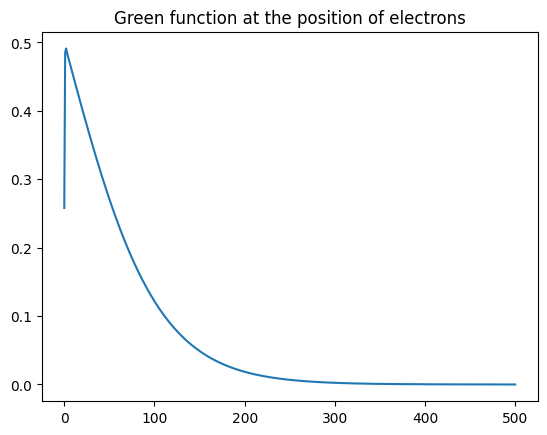

In [18]:
# # ------------ Load Green Function  ------------ #
GreenFuncName = 'Green_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(eps)) + '.npy'
G = np.load("GreenFunctions/good_versions//"+GreenFuncName)

plt.plot(G[position_of_electrons,0,:])
plt.title('Green function at the position of electrons')
plt.show()
#G = np.transpose(Gin, axes = (0, 2, 1))

In [19]:


dGr = np.zeros((N, N))
dGzTOP = np.zeros((N, N))
dGzBOTTOM = np.zeros((N, N))

# # ----------- Green function difference along the charge pool ----------- #
for n in range(0, N):
    for i in range(0, N):
        dGr[n,i] = -4*np.pi*e*(G[position_of_electrons,i+1,n]-G[position_of_electrons,i,n])
    
# # ----------- Green function difference across the cell's top ----------- #
        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz) #for testing
        

# # ----------- Green function difference across the cell's bottom ----------- #
        dGzBOTTOM[n,i] = -4 * np.pi * e * (G[1,i,n]-G[0,i,n])*(hr/hz)

## Choose the voltage sweep

In [52]:
Eztil = np.zeros(N+1)

Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Vit=0/300 #statvolt
Vmt=0/300 #statvolt
Vot=0/300 #statvolt

Vr=0/300 #statvolt

Vob=-20/300
Vmb=-20/300
Vib_start=3
Vib_stop=30
Vib_step=0.2
Vib = cp.arange(Vib_start, Vib_stop, Vib_step)/300
print(len(Vib))



135


## Calculate $\tilde \Phi$ (if it is already calculated, do not run this code)

In [10]:
def phitilGen():


    phitilInitial = fitilSOLUT(R,H,N,M,Vib[0],Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr)
    phitilList = cp.array(np.zeros((len(Vib), np.shape(phitilInitial)[0], np.shape(phitilInitial)[1])))
  
    phitilList[0] = phitilInitial
    

    for i in range(1,len(Vib)):
        print(len(Vib) - i)
        print('Vib ='+str(Vib[i]*300))
        phitilList[i] = fitilSOLUT(R,H,N,M,Vib[i],Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr)

    return phitilList

for Vmb in [-15/300, -20/300, -30/300]:
    Vob=Vmb
    phitilList = phitilGen()
    PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(1e-8)) + '_Vib_step='+ str(Vib_step).replace('.','pt')+ '_Vib_start=' +str(Vib_start).replace('.','pt') +'_Vib_stop='+ str(Vib_stop).replace('.','pt') +  '_Vmb'+ str(int(Vmb*300))+ '_Vob'+ str(int(Vob*300)) +'.npy'
    fileName = "phiFiles/Vib_sweep/" + str(PhiTilName)
    phitilNump = cp.asnumpy(phitilList)
    np.save(fileName, phitilNump)


0
9.5668133926613e-07
3.1285822418847253e-07
1.0997637159629314e-07
3.9460595173401725e-08
1.4395525944899124e-08
5.325930637484211e-09
1.994417797579473e-09
7.550409186762863e-10
2.887658098749135e-10
1.115209764812608e-10
134
Vib =3.2000000000000006
0
9.56130123248855e-07
3.122232581052875e-07
1.0957630666025286e-07
3.924428867638219e-08
1.42896544146065e-08
5.275588649961138e-09
1.9712760000734075e-09
7.446208337424931e-10
2.841201579562025e-10
1.0946548528734112e-10
133
Vib =3.4
0
9.555789072489274e-07
3.115941818801482e-07
1.091814814876968e-07
3.903127206508761e-08
1.4183961612873608e-08
5.225808119568853e-09
1.9484126256852363e-09
7.342898337980852e-10
2.79523786061997e-10
1.0743429756931988e-10
132
Vib =3.6
0
9.550276912524691e-07
3.1098700045348315e-07
1.0878665631861018e-07
3.882042103400818e-08
1.4079339829414783e-08
5.176396093015123e-09
1.925769422400636e-09
7.240870368574459e-10
2.7497562907208284e-10
1.0542709760752444e-10
131
Vib =3.8
0
9.544764752351942e-07
3.103798190

NameError: name 'Vmb_step' is not defined

### Save PhiTilList

In [12]:
PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(1e-8)) + '_Vib_step='+ str(Vib_step).replace('.','pt')+ '_Vib_start=' +str(Vib_start).replace('.','pt') +'_Vib_stop='+ str(Vib_stop).replace('.','pt') +  '_Vmb'+ str(int(Vmb*300))+ '_Vob'+ str(int(Vob*300)) +'.npy'
fileName = "phiFiles/Vib_sweep/" + str(PhiTilName)

phitilNump = cp.asnumpy(phitilList)
np.save(fileName, phitilNump)

# Eztil = np.zeros(N+1)
# Phitil = np.zeros(N+1)
# Ertil = np.zeros(N)
# EztilTOP = np.zeros(N+1)
# EztilBOTTOM = np.zeros(N+1)

## Load PhiTilList if already calculated

In [53]:
# in the filename, change the Vob step to the one you used in the phitilGen function
PhiTilName = 'Phi_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(np.log10(1e-10)) + '_Vib_step='+ str(Vib_step).replace('.','pt')+ '_Vib_start=' +str(Vib_start).replace('.','pt') +'_Vib_stop='+ str(Vib_stop).replace('.','pt') +  '_Vmb'+ str(int(Vmb*300))+ '_Vob'+ str(int(Vob*300)) +'.npy'
fileName = "phiFiles/Vib_sweep/" + str(PhiTilName)
print(PhiTilName)
phitilNump=np.load(fileName)
print(np.shape(phitilNump))

Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)


Phi_R0pt75_H0pt2_N500_M200_posiE100_epsE-10.0_Vib_step=0pt2_Vib_start=3_Vib_stop=30_Vmb-20_Vob-20.npy
(135, 201, 501)


## Saturated density profile

In [44]:
print(phitilNump.shape)
print(len(Vib))

(135, 201, 501)
135


In [54]:
#for each potential, calculates the density profile (depeding on the radus of the electron pool)
Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)
print(len(phitilNump))    

N_total_list = np.zeros(len(phitilNump))
N_per_ring_list = np.zeros((len(phitilNump), N+1))
denList = np.zeros((len(phitilNump), N+1))
density_max_list = np.zeros(len(phitilNump))
R_star_list = np.zeros(len(phitilNump))
Ertil_list=np.zeros((len(phitilNump), N))
Eztil_list = np.zeros((len(phitilNump), N+1))

for l in range(0, len(phitilNump)):


    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]

        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz


    radius_of_electron_pool = np.round(0.4/hr)
    
    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])

    
    for k in range(0, len(radius_of_electron_pool_list)):

    

        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        

        # ------------- induced charge at the top inner electrode ------------------- #
        Ez = EztilTOP[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind=Qsum/e

        # ------------- induced charge at the bottom inner electrode ------------------- #
        Ez = EztilBOTTOM[0:N]
        Qsum = np.add.reduce(Ez[0:int(N_Vit)] * A[0:int(N_Vit)]/(4 * np.pi))
        N_ind = Qsum/e
        
        # ------------  potential at/below/above the electrons ------------ #


        copyAr2D(G_at_electrons, G[position_of_electrons].T)
        copyAr2D(G_below_electrons, G[position_of_electrons-1].T)
        copyAr2D(G_above_electrons, G[position_of_electrons+1].T)
        
        phi_at_electrons = phitil[position_of_electrons] - 4 * np.pi * e * hr * np.dot(density, G_at_electrons)
        phi_below_electrons = phitil[position_of_electrons-1] - 4 * np.pi * e * hr * np.dot(density, G_below_electrons)
        phi_above_electrons = phitil[position_of_electrons+1] - 4 * np.pi * e * hr * np.dot(density, G_above_electrons)

        # ---------- electric r-field across the liquid surface  ---------- #
        Er = np.zeros(N)

        Er[0:N] = (phi_at_electrons[0:N] - phi_at_electrons[1:N+1])/hr
        
        # ------------ electric field acting on electrons  ---------------- #
        Ezbelow[0:N+1] = (phi_below_electrons[0:N+1] - phi_at_electrons[0:N+1])/hz
        Ezabove[0:N+1] = (phi_at_electrons[0:N+1] - phi_above_electrons[0:N+1])/hz
        
        # adds the electric field acting on the electrons at the center to a list 
        Ezuplist[k] = Ezabove[0]
    
    
    minimum = np.amin(np.abs(Ezuplist))
    # chooses the index of the smallest absolute value of the electric field acting on the electrons at the center
    idx = np.argmin(np.abs(Ezuplist))

    # chooses the radius of the electron pool accordingly
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    #calculates the final density profile with the chosen radius of the electron pool
    # this is done for every potential in the Vob sweep
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
    
    # check eq 56 
    print(np.max(np.abs(np.dot(density[:int(radius_of_electron_pool)+1], dGr[:int(radius_of_electron_pool)+1, :int(radius_of_electron_pool)+1]) -Ertil[:int(radius_of_electron_pool)+1])))
    
    N_total_list[l] = N_total
    print(N_total*1e-7)
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    N_per_ring_list[l] = N_per_ring
    Ertil_list[l]=Ertil
    Eztil_list[l] = Eztil

colors = plt.cm.jet(np.linspace(0,1,len(denList)))

print(N_total_list)




135
Iterations Left: 136
2.7755575615628914e-17
0.28326324294166716
Iterations Left: 135
2.6020852139652106e-17
0.3053021233431622
Iterations Left: 134
3.0357660829594124e-17
0.3398944519892123
Iterations Left: 133
3.469446951953614e-17
0.3659925207004977
Iterations Left: 132
4.85722573273506e-17
0.39393960339392736
Iterations Left: 131
3.469446951953614e-17
0.4238538501640072
Iterations Left: 130
4.163336342344337e-17
0.4558595302256543
Iterations Left: 129
4.85722573273506e-17
0.4900871201373021
Iterations Left: 128
4.163336342344337e-17
0.5266733902497005
Iterations Left: 127
4.597017211338539e-17
0.5657614019732893
Iterations Left: 126
5.204170427930421e-17
0.5886710000240333
Iterations Left: 125
3.642919299551295e-17
0.6319481408651589
Iterations Left: 124
6.938893903907228e-17
0.6572786700002001
Iterations Left: 123
5.551115123125783e-17
0.7051290779334394
Iterations Left: 122
5.0306980803327406e-17
0.733098978019582
Iterations Left: 121
4.5102810375396984e-17
0.7620595497906982


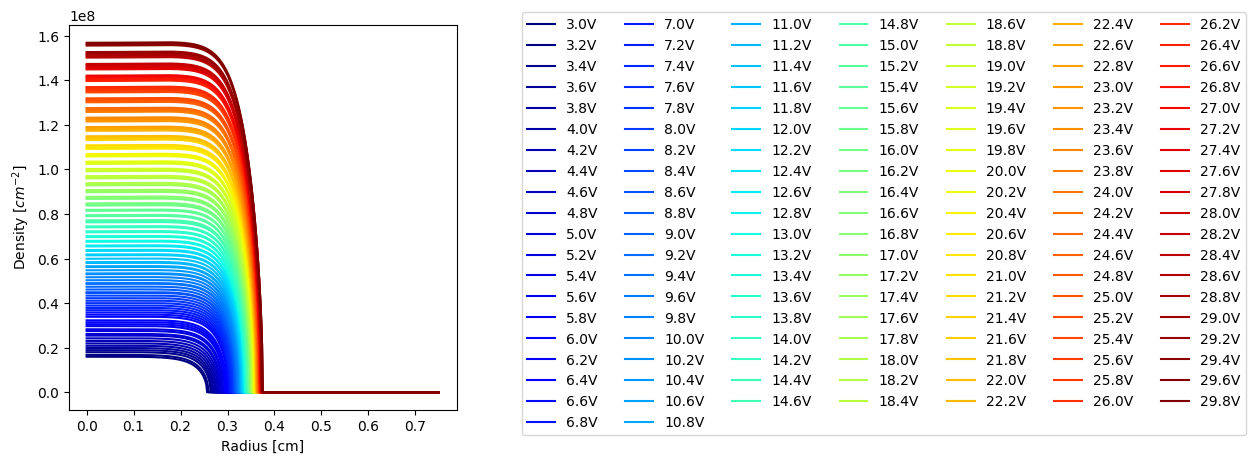

In [55]:
fig, ax = plt.subplots(1,1,figsize=(5, 5), sharex=True)

for d in range(len(phitilNump)):
    ax.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(np.round(Vib[d] * 300,1))+'V')



ax.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
ax.set_ylabel(r"Density $[cm^{-2}]$")
# ax2.set_ylabel(r"$\tilde{E^r}$ [statV/cm]")
# ax2.set_ylabel(r"$\tilde{E^z}$ [statV/cm]")
ax.set_xlabel("Radius [cm]")
# ax2.set_xlabel("Radius [cm]")
plt.show()


### Run if you want to save the saturated densities

In [56]:
for idx in range(len(denList)):
    Vib_str = f"{Vib[idx] * 300:.1f}".replace(".", "p")
    # filename = f"DensityFiles/Saturated_density/saturated_density_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    filename = f"DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib{Vib_str}_Vob{int(Vob*300)}_Vmb{int(Vmb*300)}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    print(filename)
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(filename, data_to_save)



DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib3p0_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib3p2_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib3p4_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib3p6_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib3p8_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib4p0_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib4p2_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib4p4_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib4p6_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density_Vib4p8_Vob-20_Vmb-20_N500_M200_posiE100.npy
DensityFiles/Vib_sweep_good/-20V/saturated_density

## Fixed N Density List

In [35]:
Eztil = np.zeros(N+1)
Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N+1)
EztilBOTTOM = np.zeros(N+1)

Ezbelow = np.zeros(N+1)
Ezabove = np.zeros(N+1)

N_Fixed_list = np.copy(N_total_list)

# fix the number of electrons to be equal to the number of electrons at Vob=-96V 
# indeed the sweep of Vob is done from -96V to -5.5V, so the number of electrons at Vob=-96V is the one that is fixed



N_Fixed = N_total_list[0]

for l in range(0, len(phitilNump)):
    print("Iterations Left: " + str(len(phitilNump) - l + 1))

    # ------------ homogen. potential  ------------ #
    phitil = phitilNump[l]



        # ---------- homogen. electric z-field at the el. layer (CGS) ---------- #
    Eztil[:] = (phitil[position_of_electrons-1] - phitil[position_of_electrons])/hz
    
    Phitil = phitil[position_of_electrons]
    
    # --------- homogen. electric r-field at the el. layer (CGS) ------------ #
    Ertil[0:N]=(phitil[position_of_electrons,0:N]-phitil[position_of_electrons,1:N+1])/hr

    # --------- homogen. electric z-field at the cell's top (CGS) ---------- #
    EztilTOP[:] = (phitil[M-1, :]-phitil[M,:])/hz

    # --------- homogen. electric z-field at the cell's bottom (CGS) ---------- #
    EztilBOTTOM[:] = (phitil[0, :] - phitil[1,:])/hz

    
    radius_of_electron_pool = np.round(0.4/hr)
    print(radius_of_electron_pool)
    
    #radius_of_electron_pool_list = np.arange(radius_of_electron_pool - 350,radius_of_electron_pool+1)
    radius_of_electron_pool_list = np.arange(0,radius_of_electron_pool+1)

    Ezuplist = np.zeros(len(radius_of_electron_pool_list))

    G_at_electrons = np.copy(G[position_of_electrons])
    G_below_electrons = np.copy(G[position_of_electrons-1])
    G_above_electrons = np.copy(G[position_of_electrons+1])


    N_total_vect = np.zeros(len(radius_of_electron_pool_list))
    for k in range(0, len(radius_of_electron_pool_list)):
        radius_of_electron_pool = radius_of_electron_pool_list[k]
        density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)
        N_total_vect[k] = N_total
    minimum = np.amin(np.abs(N_total_vect - N_Fixed))
    idx = np.argmin(np.abs(N_total_vect - N_Fixed))    

    
    radius_of_electron_pool = radius_of_electron_pool_list[idx]

    
    density, N_total, A, N_per_ring = distribSTATIC(R,H,N,M,G,Ertil, dGr,radius_of_electron_pool)

    
    N_total_list[l] = N_total
    denList[l] = density
    density_max = np.amax(np.abs(density))
    density_max_list[l] = density_max
    R_star = np.sqrt(N_total/(density_max * np.pi))
    R_star_list[l] = R_star
    print((N_total-N_Fixed)/N_Fixed)
    


Iterations Left: 211
267.0
0.0
Iterations Left: 210
267.0
-0.004402862500283465
Iterations Left: 209
267.0
-0.008805627556208256
Iterations Left: 208
267.0
-0.013208539699117327
Iterations Left: 207
267.0
0.012184895553067517
Iterations Left: 206
267.0
0.007649496122009492
Iterations Left: 205
267.0
0.0031132089617886037
Iterations Left: 204
267.0
-0.001422675451048577
Iterations Left: 203
267.0
-0.00595858660410789
Iterations Left: 202
267.0
-0.010495082191339357
Iterations Left: 201
267.0
0.014747670603670101
Iterations Left: 200
267.0
0.01007515916478573
Iterations Left: 199
267.0
0.005402738898982935
Iterations Left: 198
267.0
0.0007291455121932624
Iterations Left: 197
267.0
-0.00394390939688195
Iterations Left: 196
267.0
-0.008616995613977786
Iterations Left: 195
267.0
-0.013290571399773639
Iterations Left: 194
267.0
0.011632086440639781
Iterations Left: 193
267.0
0.006818779856731922
Iterations Left: 192
267.0
0.00200496765672544
Iterations Left: 191
267.0
-0.0028088819541302176


<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_20796\1919660459.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f'Density profile for different Vmb potentials ($\epsilon={eps} ,N={N}, M={M}$)')


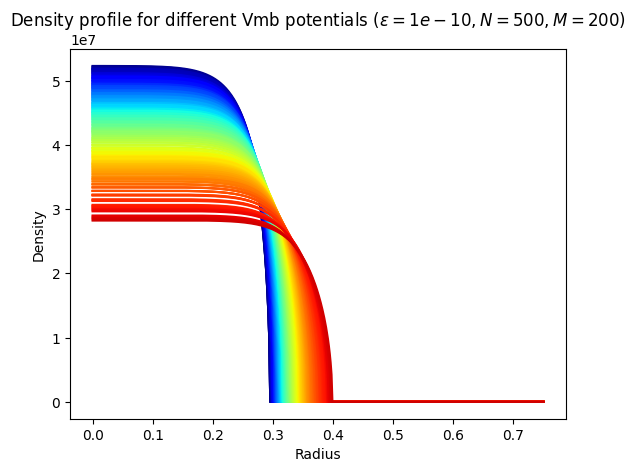

In [36]:
colors = plt.cm.jet(np.linspace(0,1,len(denList)))
for d in range(0, 195):
    plt.plot(np.arange(0, len(denList[d])) * hr,denList[d], color = colors[d], label = str(Vmb[d] * 300)+'V')

plt.ylabel("Density")
plt.xlabel("Radius")
# plt.legend(ncol=np.ceil(len(denList)/20), bbox_to_anchor=(1.15, 1.05))
plt.title(f'Density profile for different Vmb potentials ($\epsilon={eps} ,N={N}, M={M}$)')
plt.show()


plt.show()

In [ ]:
#the file DensityFiles/EPS{int(np.log10(eps))} needs to be created before running the code
for idx in range(len(denList)):
    Vib_str = f"{Vib[idx] * 300:.1f}".replace(".", "p")
    # filename = f"DensityFiles/Saturated_density/saturated_density_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    filename = f"DensityFiles/Vib_sweep_good/-15V/FixedN_Vib{Vib_str}_Vob{int(Vob*300)}_Vmb{int(Vmb*300)}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    # filename = f"DensityFiles/EPS{int(np.log10(eps))}/FixedN_Vib{int(Vib*300)}_Vmb{int(Vmb*300)}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
    print(filename)
    radius = np.arange(0, len(denList[d])) * hr
    data_to_save = np.array([radius, denList[idx]])
    np.save(filename, data_to_save)



DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-32p0_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-31p8_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-31p6_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-31p4_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-31p2_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-31p0_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-30p8_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-30p6_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-30p4_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-30p2_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-30p0_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-29p8_N500_M200_posiE100.npy
DensityFiles/Vmb_sweep2/FixedN_Vib10_Vob-32_Vmb-29p6_N500_M200_posiE100.npy
DensityFiles